# Traffic Sign Image Classification Project

Bu proje, trafik işareti görüntülerini sınıflandırmak için bir Evrişimli Sinir Ağı (CNN) kullanmaktadır. 
Model şu şekilde çalışır:

1. Veri Hazırlama:
   - Trafik işareti görüntüleri yüklenir ve 30x30 piksel boyutuna yeniden boyutlandırılır.
   - Veriler eğitim ve test setlerine ayrılır.
   - Etiketler one-hot encoding formatına dönüştürülür.

2. Model Mimarisi:
   - Model, birkaç evrişim katmanı, maksimum havuzlama katmanları, dropout katmanları ve tam bağlantılı katmanlardan oluşur.
   - Son katman, 43 farklı trafik işareti sınıfı için softmax aktivasyonu kullanır.

3. Model Eğitimi:
   - Model, kategorik çapraz entropi kaybı ve Adam optimizasyonu kullanılarak derlenir.
   - Eğitim, 35 epoch boyunca GPU üzerinde gerçekleştirilir.

4. Değerlendirme:
   - Model, ayrı bir test seti üzerinde değerlendirilir.
   - Doğruluk skoru hesaplanarak modelin performansı ölçülür.

5. Görselleştirme ve Kaydetme:
   - Eğitim süreci boyunca modelin performansı görselleştirilir.
   - Eğitilmiş model, daha sonra kullanılmak üzere kaydedilir.

Bu model, trafik işaretlerini yüksek doğrulukla sınıflandırarak sürücü destek sistemleri ve otonom araçlar için potansiyel uygulamalara sahiptir.

https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/data

https://www.kaggle.com/code/yacharki/traffic-signs-image-classification-97-cnn

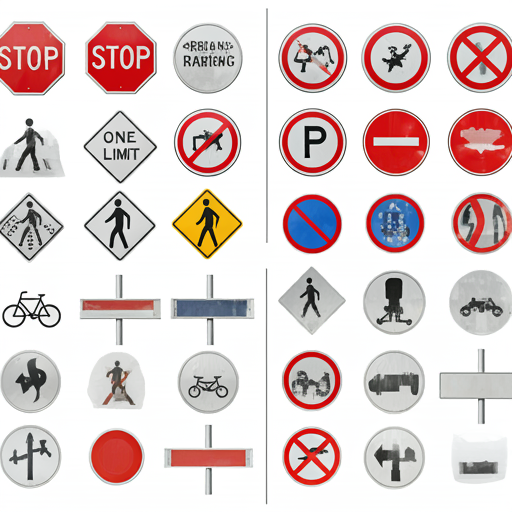

## 1. İndirme ve İçe Aktarmalar

In [1]:
# Temel kütüphaneler
import numpy as np # Sayısal işlemler için NumPy
import pandas as pd # Veri manipülasyonu için Pandas
import tensorflow as tf # Derin öğrenme için TensorFlow
import os # Dosya ve dizin işlemleri için

# Görüntü işleme kütüphaneleri
import cv2 # OpenCV kütüphanesi
from PIL import Image # Python Imaging Library

# Performans grafikleri için kütüphaneler
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Model oluşturma ve eğitim için kütüphaneler
from sklearn.model_selection import train_test_split # Veri bölme
from tensorflow.keras.utils import to_categorical # Etiketleri kategorik hale getirme
from tensorflow.keras.models import Sequential, load_model # Sıralı model oluşturma
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout # Model katmanları

# Zaman işlemleri için kütüphaneler
import time
import datetime

## 2. Yardımcı Fonksiyonlar

In [2]:
# Tarih ve saat bilgisi döndüren fonksiyon # Fonksiyon açıklaması
def date_time(x): # date_time fonksiyonunu tanımla
    if x == 1: # Eğer x 1 ise
        return 'Zaman Damgası: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()) # Yıl-ay-gün saat:dakika:saniye formatında zaman damgası döndür
    if x == 2: # Eğer x 2 ise    
        return 'Zaman Damgası: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()) # Yıl-ay(kısa)-gün saat:dakika:saniye formatında zaman damgası döndür
    if x == 3: # Eğer x 3 ise  
        return 'Şu anki tarih: %s' % datetime.datetime.now() # Şu anki tarihi döndür
    if x == 4: # Eğer x 4 ise  
        return 'Bugünün tarihi: %s' % datetime.date.today() # Bugünün tarihini döndür

In [3]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]): # Model performansını gösteren grafik fonksiyonunu tanımla
    xlabel = 'Epoch' # x ekseni etiketi
    legends = ['Training', 'Validation'] # Grafik lejantları

    plt.figure(figsize=(20, 5)) # 20x5 boyutunda bir figür oluştur

    y1 = history.history['accuracy'] # Eğitim doğruluk değerlerini al
    y2 = history.history['val_accuracy'] # Doğrulama doğruluk değerlerini al

    min_y = min(min(y1), min(y2))-ylim_pad[0] # y ekseninin minimum değerini hesapla
    max_y = max(max(y1), max(y2))+ylim_pad[0] # y ekseninin maksimum değerini hesapla

    plt.subplot(121) # İlk alt grafik

    plt.plot(y1) # Eğitim doğruluk grafiğini çiz
    plt.plot(y2) # Doğrulama doğruluk grafiğini çiz

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17) # Grafik başlığını ayarla
    plt.xlabel(xlabel, fontsize=15) # x ekseni etiketini ayarla
    plt.ylabel('Accuracy', fontsize=15) # y ekseni etiketini ayarla
    plt.ylim(min_y, max_y) # y ekseni limitlerini ayarla
    plt.legend(legends, loc='upper left') # Grafik lejantını ayarla
    plt.grid() # Izgara ekle

    y1 = history.history['loss'] # Eğitim kayıp değerlerini al
    y2 = history.history['val_loss'] # Doğrulama kayıp değerlerini al

    min_y = min(min(y1), min(y2))-ylim_pad[1] # y ekseninin minimum değerini hesapla
    max_y = max(max(y1), max(y2))+ylim_pad[1] # y ekseninin maksimum değerini hesapla

    plt.subplot(122) # İkinci alt grafik

    plt.plot(y1) # Eğitim kayıp grafiğini çiz
    plt.plot(y2) # Doğrulama kayıp grafiğini çiz

    plt.title('Model Loss\n'+date_time(1), fontsize=17) # Grafik başlığını ayarla
    plt.xlabel(xlabel, fontsize=15) # x ekseni etiketini ayarla
    plt.ylabel('Loss', fontsize=15) # y ekseni etiketini ayarla
    plt.ylim(min_y, max_y) # y ekseni limitlerini ayarla
    plt.legend(legends, loc='upper left') # Grafik lejantını ayarla
    plt.grid() # Izgara ekle
    if figure_directory: # Eğer figure_directory belirtilmişse
        plt.savefig(figure_directory+"/history") # Grafiği kaydet

    plt.show() # Grafiği göster

## 3. Veri Setinin Yüklenmesi (Trafik İşareti Görüntüleri)

In [4]:
# Değişkenlerin tanımlanması
data = [] # Görüntüleri tutacak boş liste oluştur
labels = [] # Etiketleri tutacak boş liste oluştur
classes = 43 # Toplam sınıf sayısını belirle
cur_path = os.getcwd() # Mevcut çalışma dizinini al

# Görüntülerin ve etiketlerinin yüklenmesi
for i in range(classes): # Her sınıf için döngü
    path = os.path.join('../input/gtsrb-german-traffic-sign/','train',str(i)) # Sınıf klasörünün yolunu oluştur
    images = os.listdir(path) # Klasördeki dosyaları listele

    for a in images: # Her görüntü için döngü
        try: # Hata yönetimi bloğu başlangıcı
            image = Image.open(path + '/'+ a) # Görüntüyü aç
            image = image.resize((30,30)) # Görüntüyü 30x30 boyutuna yeniden boyutlandır
            image = np.array(image) # Görüntüyü numpy dizisine çevir
            data.append(image) # Görüntüyü data listesine ekle
            labels.append(i) # Etiketi labels listesine ekle
        except: # Hata durumunda
            print("Görüntü yüklenirken hata oluştu") # Hata mesajı yazdır

# Listeleri numpy dizilerine çevirme
data = np.array(data) # data listesini numpy dizisine çevir
labels = np.array(labels) # labels listesini numpy dizisine çevir


## 4. Veri Bölme ve Dönüştürme

In [6]:
# Veri şeklini kontrol etm
print(data.shape, labels.shape) # Veri ve etiket dizilerinin şeklini yazdır

# Eğitim ve test verilerini bölme
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42) # Veriyi eğitim ve test setlerine böl

# Bölünmüş veri şekillerini gösterme
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) # Bölünmüş veri setlerinin şekillerini yazdır

# Etiketleri one-hot encoding formatına çevirme
y_train = to_categorical(y_train, 43) # Eğitim etiketlerini kategorik formata çevir
y_test = to_categorical(y_test, 43) # Test etiketlerini kategorik formata çevir


(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


## 5. Model Oluşturma ve Derleme

In [7]:
# Modeli oluşturma
model = Sequential() # Sıralı bir model oluştur
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:])) # İlk konvolüsyon katmanını ekle
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu')) # İkinci konvolüsyon katmanını ekle
model.add(MaxPool2D(pool_size=(2, 2))) # Maksimum havuzlama katmanı ekle
model.add(Dropout(rate=0.15)) # Dropout katmanı ekle
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu')) # Üçüncü konvolüsyon katmanını ekle
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu')) # Dördüncü konvolüsyon katmanını ekle
model.add(MaxPool2D(pool_size=(2, 2))) # İkinci maksimum havuzlama katmanı ekle
model.add(Dropout(rate=0.20)) # İkinci dropout katmanı ekle
model.add(Flatten()) # Düzleştirme katmanı ekle
model.add(Dense(512, activation='relu')) # Tam bağlantılı katman ekle
model.add(Dropout(rate=0.25)) # Üçüncü dropout katmanı ekle
model.add(Dense(43, activation='softmax')) # Çıkış katmanı ekle

# Modeli derleme
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Modeli derle

# Model özetini gösterme
model.summary() # Model özetini yazdır


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,624,939 (6.20 MB)

 Trainable params: 1,624,939 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Modeli Eğitme

In [8]:
# GPU kullanarak modeli eğitme
with tf.device('/GPU:0'): # GPU kullanımını belirt
    epochs = 35 # Epoch sayısını belirle
    history1 = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_test, y_test)) # Modeli eğit

Epoch 1/35


I0000 00:00:1726239773.378586     118 service.cc:145] XLA service 0x7adff8006850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726239773.378635     118 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 24/246 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0450 - loss: 15.8834

I0000 00:00:1726239780.007421     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.3450 - loss: 4.6982 - val_accuracy: 0.9421 - val_loss: 0.2312
Epoch 2/35
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9195 - loss: 0.3010 - val_accuracy: 0.9728 - val_loss: 0.1112
Epoch 3/35
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9560 - loss: 0.1656 - val_accuracy: 0.9880 - val_loss: 0.0638
Epoch 4/35
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9755 - loss: 0.0911 - val_accuracy: 0.9939 - val_loss: 0.0361
Epoch 5/35
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9826 - loss: 0.0604 - val_accuracy: 0.9895 - val_loss: 0.0506
Epoch 6/35
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9842 - loss: 0.0581 - val_accuracy: 0.9921 - val_loss: 0.0352
Epoch 7/35
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9826 - loss: 0.0648 - val_accuracy: 0.9797 - val_loss: 0.0817
Epoch 8/35
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9489 - loss: 0.1907 - val_accuracy: 0.9931 - va

## 7. Eğitim Sırasında Model Performansını Görselleştirme

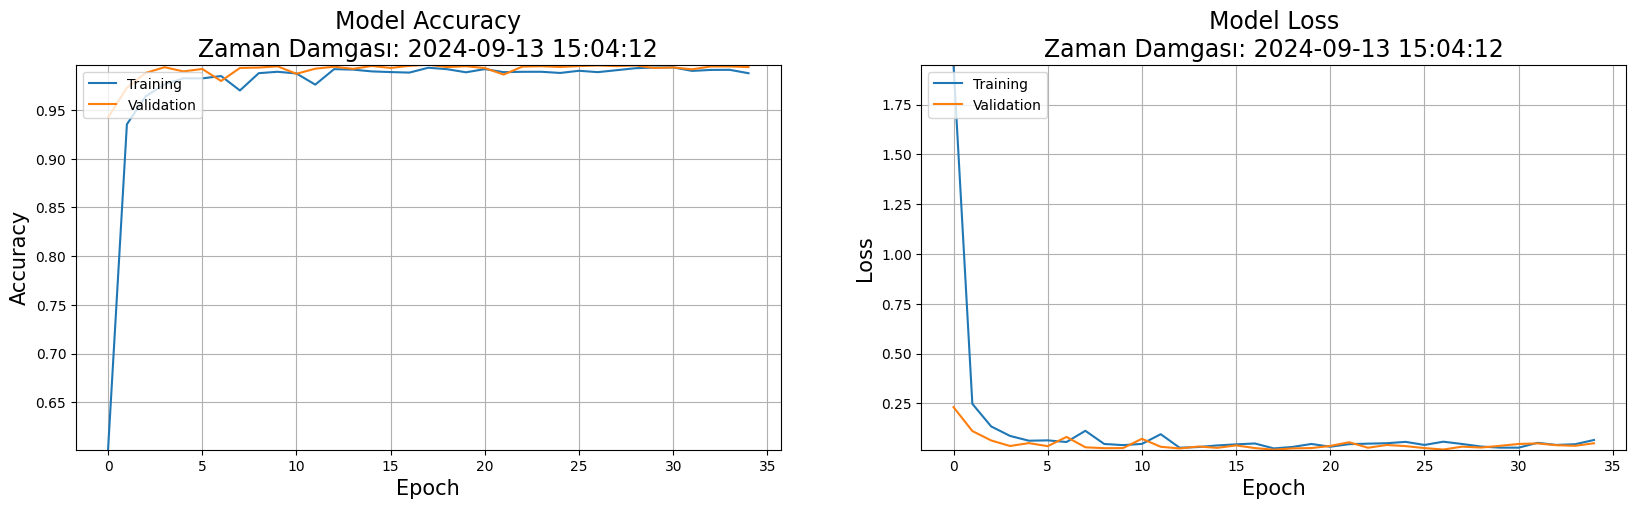

In [9]:
plot_performance(history=history1) # Eğitim performansını gösteren grafiği çiz

## 8. Test Veri Setini Yükleme ve Modeli Değerlendirme

In [10]:
y_test = pd.read_csv('../input/gtsrb-german-traffic-sign/Test.csv') # Test veri setini yükle

labels = y_test["ClassId"].values # Test etiketlerini al
imgs = y_test["Path"].values # Test görüntü yollarını al

data = [] # Boş liste oluştur

# Test görüntülerini yükleme # Alt başlık
with tf.device('/GPU:0'): # GPU kullanımını belirt
    for img in imgs: # Her görüntü için döngü
        image = Image.open('../input/gtsrb-german-traffic-sign/'+img) # Görüntüyü aç
        image = image.resize([30, 30]) # Görüntüyü yeniden boyutlandır
        data.append(np.array(image)) # Görüntüyü listeye ekle

X_test = np.array(data) # Test verilerini numpy dizisine çevir

# Modeli test etme ve doğruluk oranını hesaplama # Alt başlık
with tf.device('/GPU:0'): # GPU kullanımını belirt
    pred = np.argmax(model.predict(X_test), axis=-1) # Test verilerini tahmin et

print(accuracy_score(labels, pred)) # Doğruluk skorunu yazdır

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
0.9688836104513064


## 9. Modeli Kaydetme

In [11]:
model.save('traffic_classifier.h5') # Eğitilmiş modeli kaydet